In [2]:
# Import all necessary libraries 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_selection import SelectKBest, mutual_info_classif

#import warnings
#warnings.filterwarnings("ignore")

# Data Exploration

In [3]:
# Load data
data = pd.read_csv("./dataset.csv")
data = data.astype(int)
data

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,1,45,0,0,0,0,1,...,1,0,3,0,5,0,1,5,6,7
253676,2,1,1,1,18,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,0,1,28,0,0,0,1,1,...,1,0,1,0,0,0,0,2,5,2
253678,0,1,0,1,23,0,0,0,0,1,...,1,0,3,0,0,0,1,7,5,1


### Data types exploration

In [3]:
data_types = data.dtypes
data_types

Diabetes_012            int64
HighBP                  int64
HighChol                int64
CholCheck               int64
BMI                     int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
Fruits                  int64
Veggies                 int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
MentHlth                int64
PhysHlth                int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
dtype: object

# Data preprocessing and visualisation

### Dublicates. Missing Values and Outliers

In [5]:
#check data's integrity
data.duplicated()
int(data.duplicated().sum())


23899

This are a lot of duplicates but I assume that this happens verry quick, even if it is really a different patient, with such a huge amount of categorical 2 group variables. Because of this it would be bad to drop dublicates and keep respectively the first of them.

In [6]:
#check for missing values
data.isna().sum(axis=1)
data.isna().any(axis=1).any()

np.False_

<- no missing values

Features and Label

In [4]:
X=data.drop(['Diabetes_012'], axis=1)
y=data['Diabetes_012']
X.shape

(253680, 21)

Compute correlation matrix

In [110]:
corr_data=data.drop(['Sex'], axis=1)
corr_matrix = corr_data.corr().abs() #abs trat negative values same as positive
corr_matrix

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income
Diabetes_012,1.000000,0.271596,0.209085,0.067546,0.224379,0.062914,0.107179,0.180272,0.121947,0.042192,...,0.057882,0.015410,0.035436,0.302587,0.073507,0.176287,0.224239,0.185026,0.130517,0.171483
HighBP,0.271596,1.000000,0.298199,0.098508,0.213748,0.096991,0.129575,0.209361,0.125267,0.040555,...,0.003972,0.038425,0.017358,0.300530,0.056456,0.161212,0.223618,0.344452,0.141358,0.171235
HighChol,0.209085,0.298199,1.000000,0.085642,0.106722,0.091299,0.092620,0.180765,0.078046,0.040859,...,0.011543,0.042230,0.013310,0.208426,0.062069,0.121751,0.144672,0.272318,0.070802,0.085459
CholCheck,0.067546,0.098508,0.085642,1.000000,0.034495,0.009929,0.024158,0.044206,0.004190,0.023849,...,0.023730,0.117626,0.058255,0.046589,0.008366,0.031775,0.040585,0.090321,0.001510,0.014259
BMI,0.224379,0.213748,0.106722,0.034495,1.000000,0.013804,0.020153,0.052904,0.147294,0.087518,...,0.048736,0.018471,0.058206,0.239185,0.085310,0.121141,0.197078,0.036618,0.103932,0.100069
Smoker,0.062914,0.096991,0.091299,0.009929,0.013804,1.000000,0.061173,0.114441,0.087401,0.077666,...,0.101619,0.023251,0.048946,0.163143,0.092196,0.116460,0.122463,0.120641,0.161955,0.123937
Stroke,0.107179,0.129575,0.092620,0.024158,0.020153,0.061173,1.000000,0.203002,0.069151,0.013389,...,0.016950,0.008776,0.034804,0.177942,0.070172,0.148944,0.176567,0.126974,0.076009,0.128599
HeartDiseaseorAttack,0.180272,0.209361,0.180765,0.044206,0.052904,0.114441,0.203002,1.000000,0.087299,0.019790,...,0.028991,0.018734,0.031000,0.258383,0.064621,0.181698,0.212709,0.221618,0.099600,0.141011
PhysActivity,0.121947,0.125267,0.078046,0.004190,0.147294,0.087401,0.069151,0.087299,1.000000,0.142756,...,0.012392,0.035505,0.061638,0.266186,0.125587,0.219230,0.253174,0.092511,0.199658,0.198539
Fruits,0.042192,0.040555,0.040859,0.023849,0.087518,0.077666,0.013389,0.019790,0.142756,1.000000,...,0.035288,0.031544,0.044243,0.103854,0.068217,0.044633,0.048352,0.064547,0.110187,0.079929


Plot correlation matrix

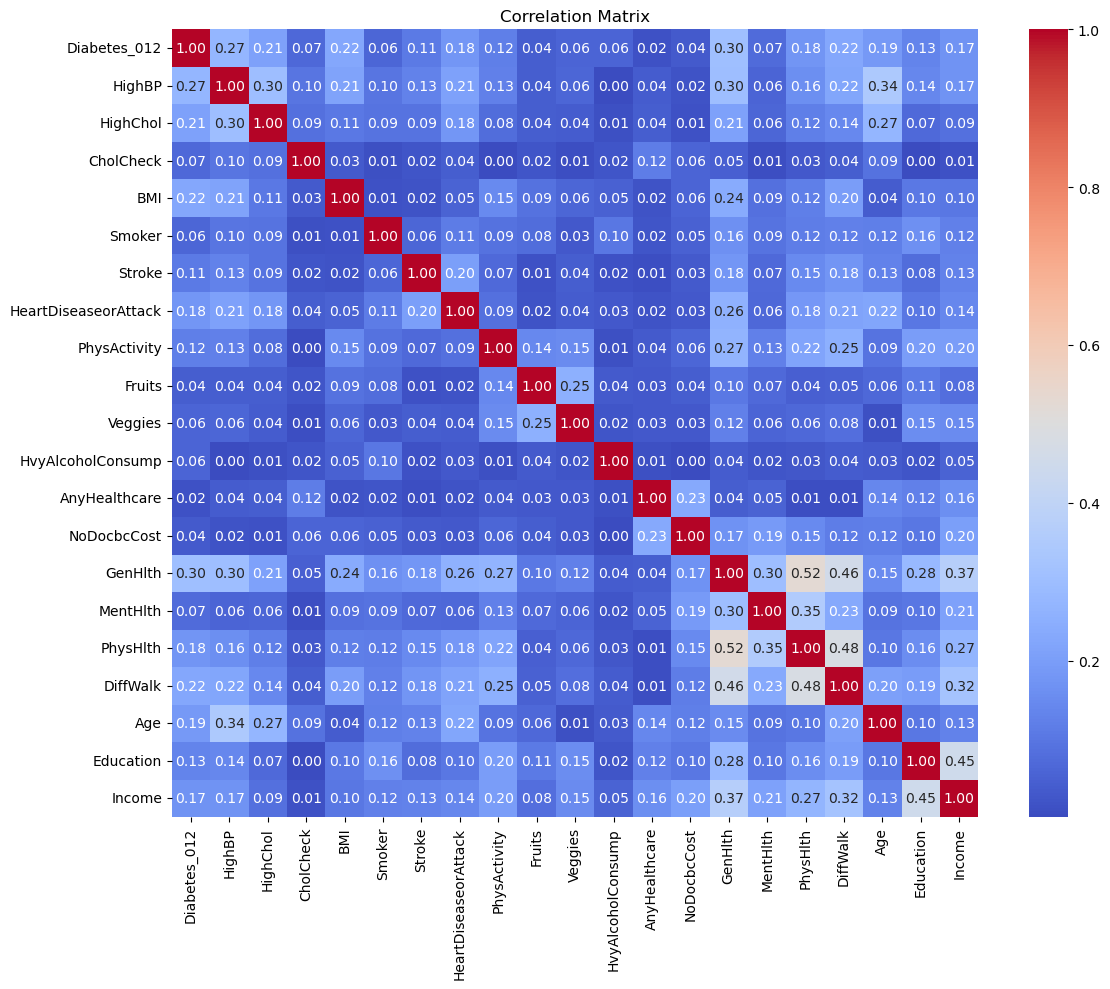

In [111]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()


Remove higly correlated variables

In [9]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.9 (threshold is adjustable)
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop redundant features
X_reduced = X.drop(columns=to_drop)
print(f"Removed {len(to_drop)} highly correlated features: {to_drop}")

Removed 0 highly correlated features: []


Use mutual information filter methods to quantify the amount of information that one variable provides about another

In [71]:
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_new = selector.fit_transform(X, y)

Let's try backword stepwise elimination (with multinominal logistische regression)

In [23]:
import statsmodels.api as sm

#Add constant for intercept
def multinomial(X): 
    X = sm.add_constant(X)
    cols = list(X.columns)
    pmax = 1

    while len(cols) > 0:
        # Inside your while loop:
        model = sm.MNLogit(y, X[cols]).fit(disp=0)

        # Take max p-value per feature across classes
        p_values = model.pvalues
        p_values_max = p_values.max(axis=1)
        pmax = p_values_max.max()
        feature_with_p_max = p_values_max.idxmax()

        # Backward elimination step
        if pmax > 0.05:
            print(f"Dropping '{feature_with_p_max}' with p = {pmax:.4f}")
            cols.remove(feature_with_p_max)
        else:
            break

    print(f"Selected features: {cols}")
    return cols

X_BSE_list = multinomial(X)
X_BSE_list.remove('const')
X_postBSE = X[X_BSE_list]


Dropping 'PhysActivity' with p = 0.7308
Dropping 'DiffWalk' with p = 0.5998
Dropping 'Smoker' with p = 0.5562
Dropping 'HeartDiseaseorAttack' with p = 0.5250
Dropping 'Fruits' with p = 0.4939
Dropping 'AnyHealthcare' with p = 0.2242
Dropping 'NoDocbcCost' with p = 0.1240
Dropping 'Veggies' with p = 0.1182
Dropping 'Stroke' with p = 0.0915
Selected features: ['const', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'Sex', 'Age', 'Education', 'Income']


LABEL, CATEGORICAL AND NUMERICAL FEATURES

**Numerical (Interval data** <- has no meaningful zero **) :** 
BMI

**Categorical (Ordinal data) :**
Diabetes_012, Age, GenHlth, MentHlth, PhyaHlth, Education, Income) 

**Categorical (Nominal data) :** Rest 
-> (HighBP, HighChol, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, DiffWalk, Sex) 

In [14]:
label = ['Diabetes_012']
num_cols = ['BMI', 'Age']
cate_cols = data.columns.drop(['BMI', 'Age', 'Diabetes_012'])

### Data Visualisation

Distribution label Diabetes:

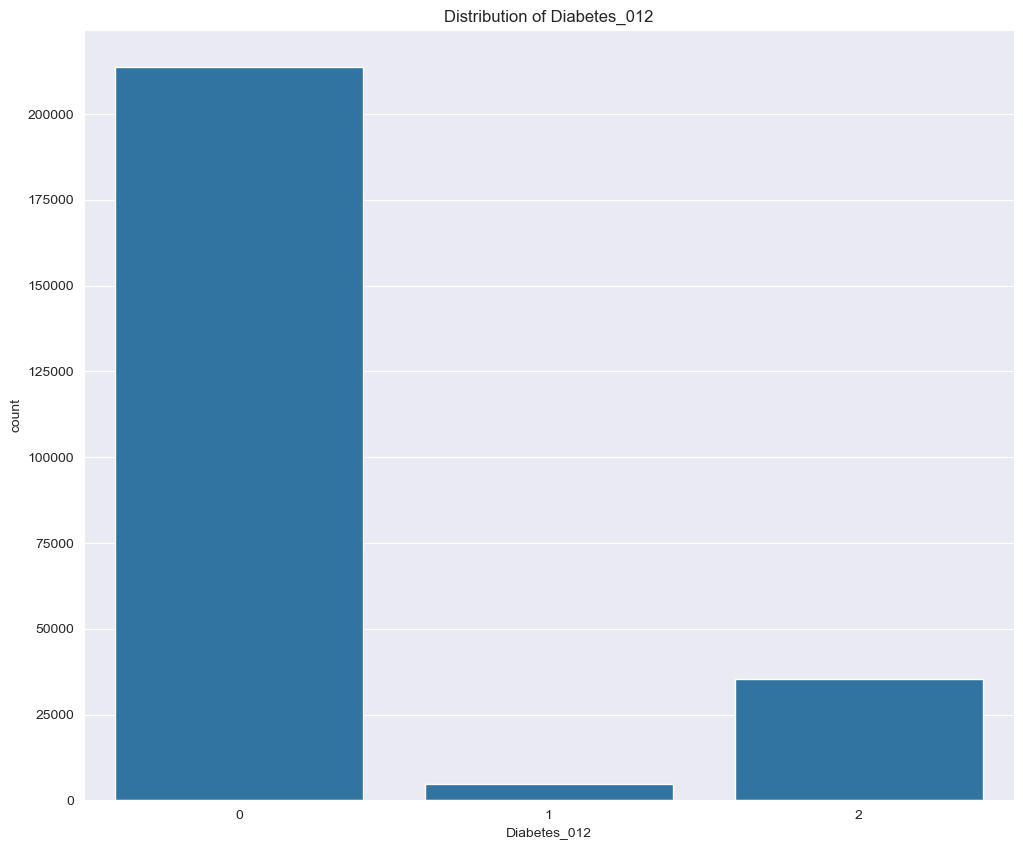

In [14]:
plt.figure(figsize=(12, 10))
sns.countplot(data=data, x='Diabetes_012')
plt.title('Distribution of Diabetes_012')
plt.show()

For the numerical features. See if there is a difference between Diabetes_012

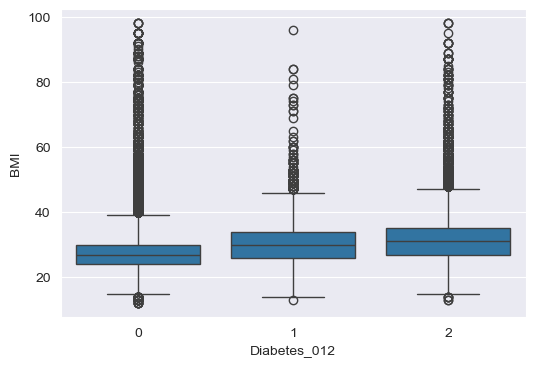

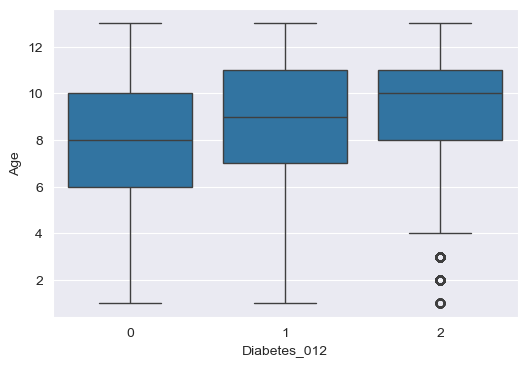

In [15]:
for i in range(len(num_cols)):
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=data, x='Diabetes_012', y=num_cols[i])
    plt.show()

Many outliers in BMI?

In [16]:
#Suggestion from Noemi:


➡ **Box Plot:** Use a box plot to show the data distribution and identify **outliers**. This type of chart works well when you have a lot of data and want to see the range and median of the data. A box-and-whisker plot displays the summary of a set of data:  the minimum, first quartile, median, third quartile, and maximum of the data subset. 

➡**Violin plots**: Use a box plot to visualize distribution and probability.  This hybrid chart works  version to shows the full distribution of the data and the peaks in the numeric dataset.  

➡ **Bar Chart:** Use a bar chart to compare categories or groups. This chart type works well when the data is discrete and not continuous.

Look at the distribution of every categorical variable

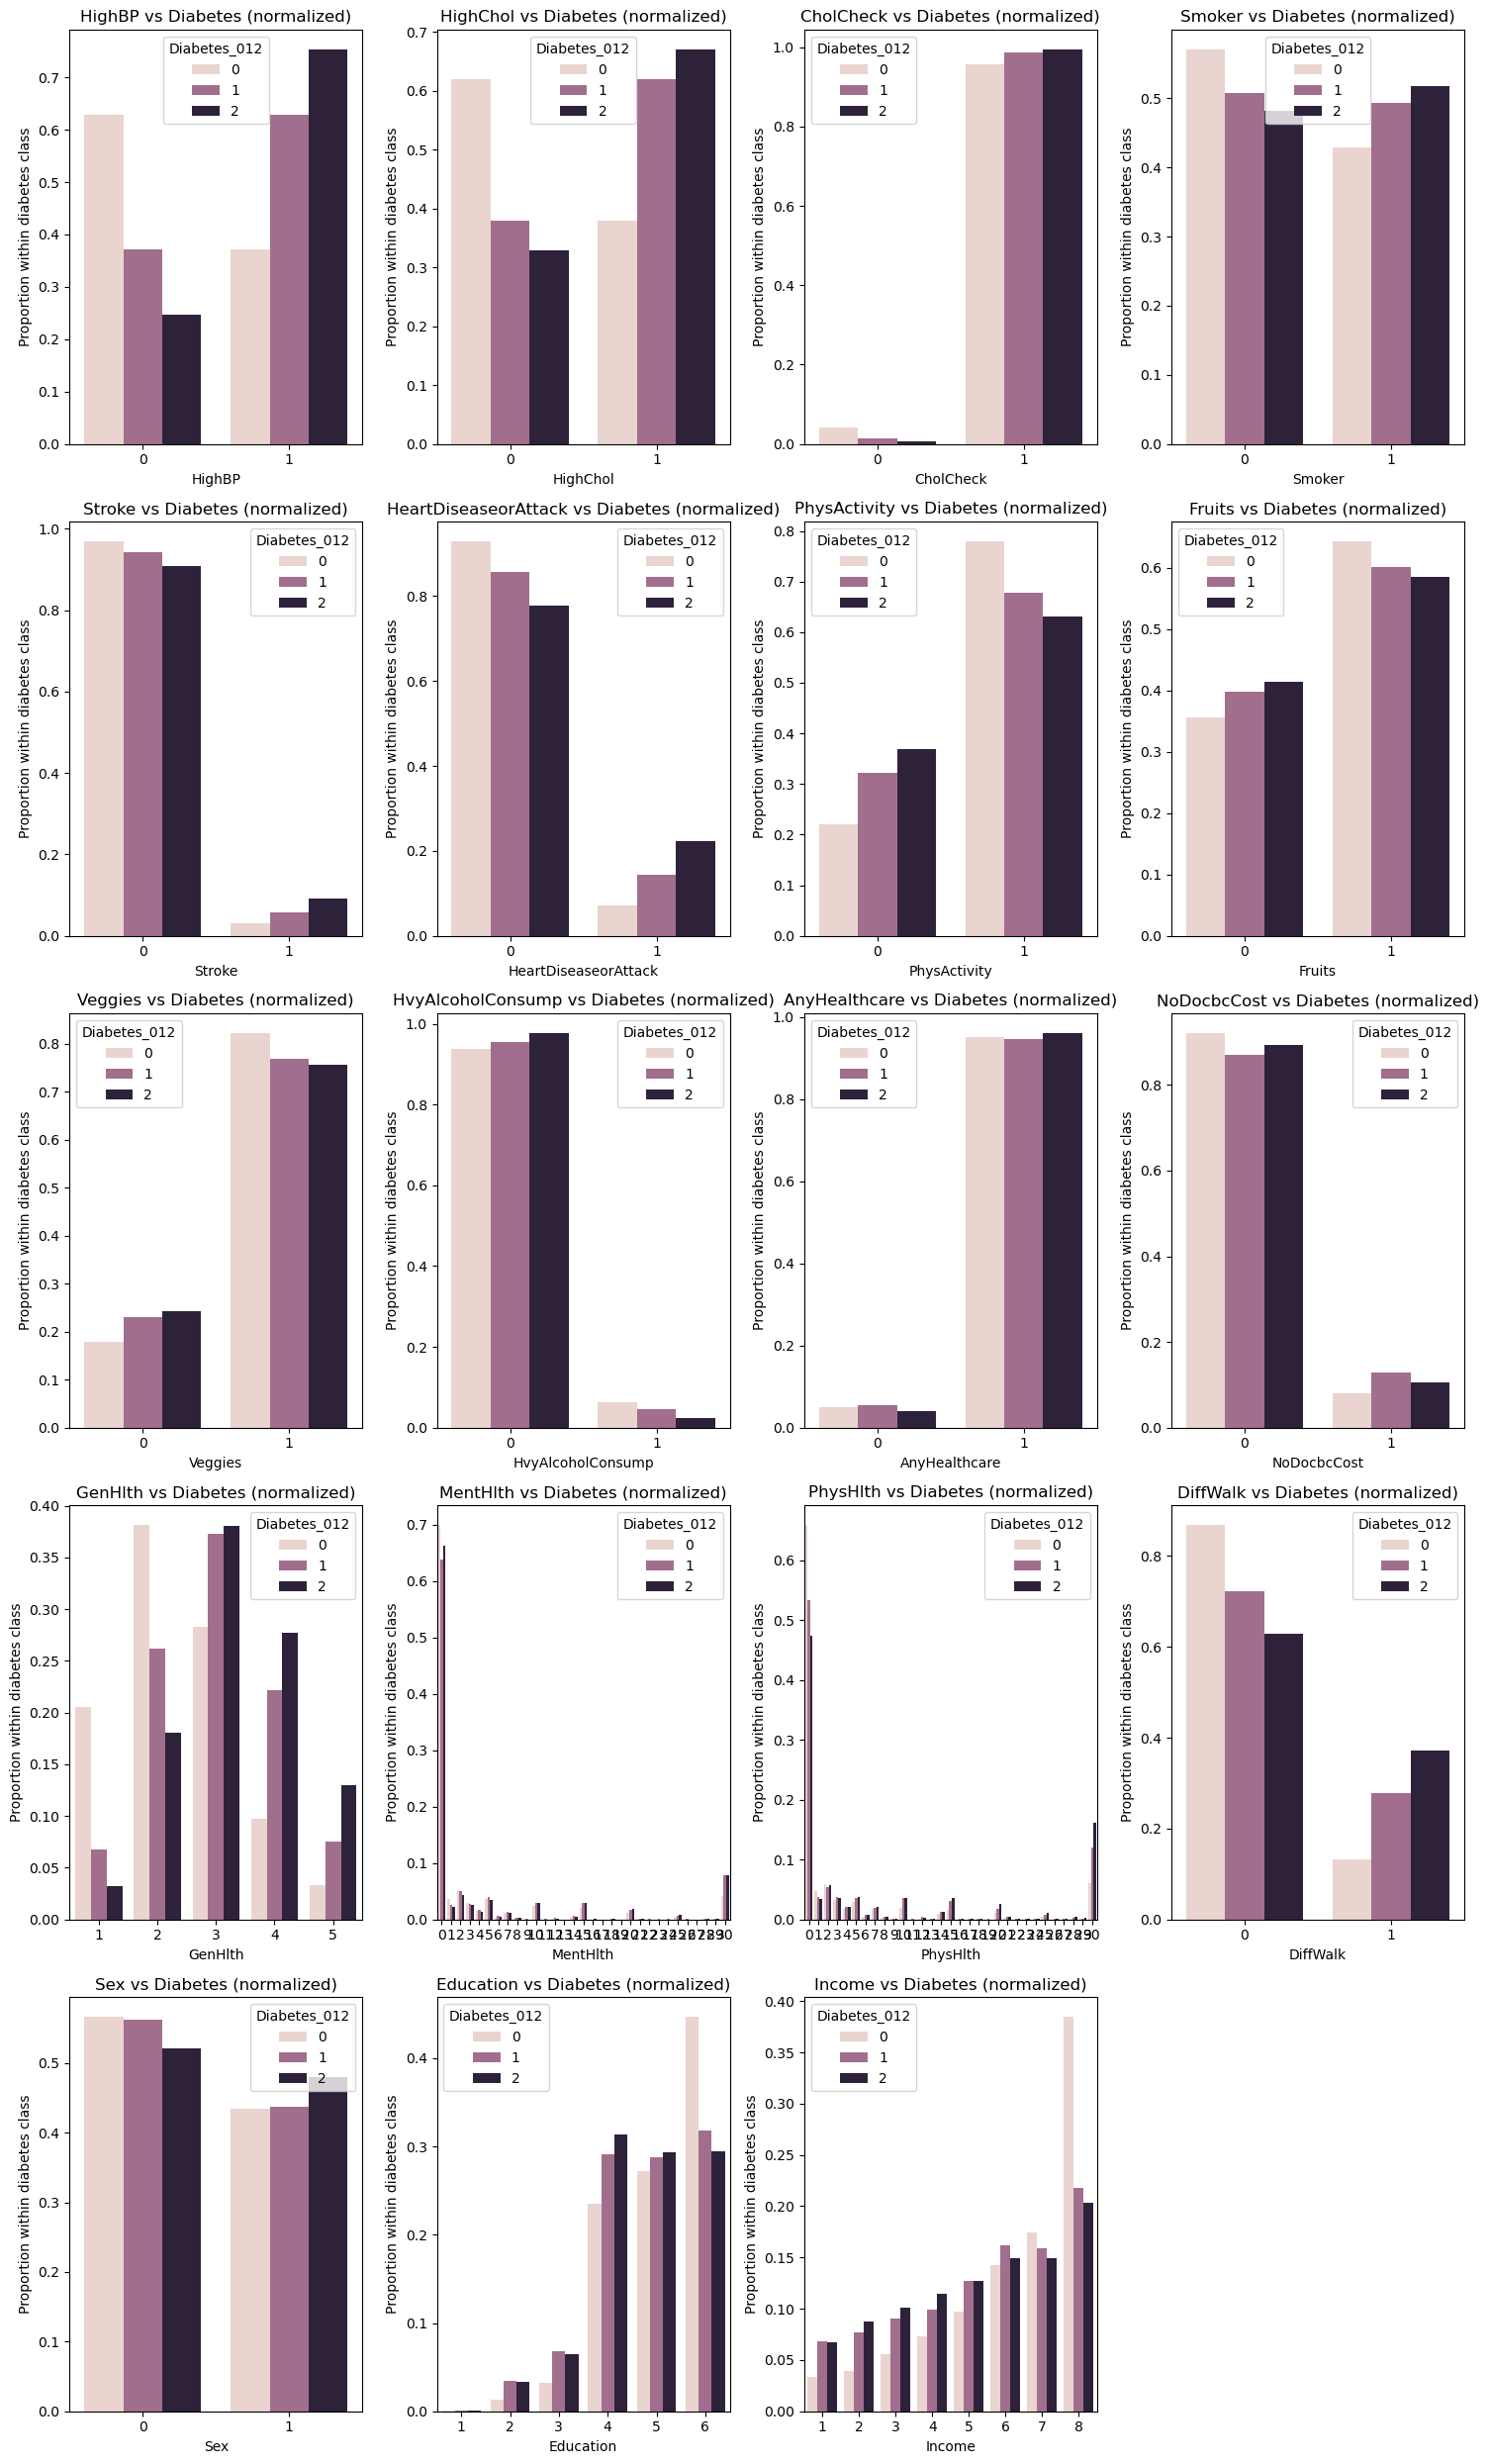

In [106]:

"""
for col in cate_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=data, x=col, hue='Diabetes_012')
    plt.title(f'{col} vs Diabetes')
    plt.show()

for col in cate_cols:
    # Step 1: Count (groupby) how many per col & diabetes class
    grouped = data.groupby(['Diabetes_012', col]).size().reset_index(name='count')
    
    # Step 2: Normalize by total in each Diabetes_012 group
    total_per_class = grouped.groupby('Diabetes_012')['count'].transform('sum')
    grouped['normalized'] = grouped['count'] / total_per_class

    # Step 3: Plot (preserve your original layout, but normalized)
    plt.figure(figsize=(10, 5))
    sns.barplot(data=grouped, x=col, y='normalized', hue='Diabetes_012')
    plt.title(f'{col} vs Diabetes (normalized by diabetes class size)')
    plt.ylabel('Proportion within diabetes class')
    plt.tight_layout()
    plt.show()
"""

num_cols = len(cate_cols)
cols = 4  # Number of subplot columns you want
rows = (num_cols + cols - 1) // cols  # Calculate rows needed to fit all plots

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten in case axes is 2D

for i, col in enumerate(cate_cols):
    # Step 1: Count (groupby) how many per col & diabetes class
    grouped = data.groupby(['Diabetes_012', col]).size().reset_index(name='count')
    
    # Step 2: Normalize by total in each Diabetes_012 group
    total_per_class = grouped.groupby('Diabetes_012')['count'].transform('sum')
    grouped['normalized'] = grouped['count'] / total_per_class
    
    # Step 3: Plot on the ith subplot axis
    sns.barplot(data=grouped, x=col, y='normalized', hue='Diabetes_012', ax=axes[i])
    axes[i].set_title(f'{col} vs Diabetes (normalized)')
    axes[i].set_ylabel('Proportion within diabetes class')
    axes[i].legend(title='Diabetes_012')

# Remove any unused subplots if number of cate_cols is not a multiple of cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


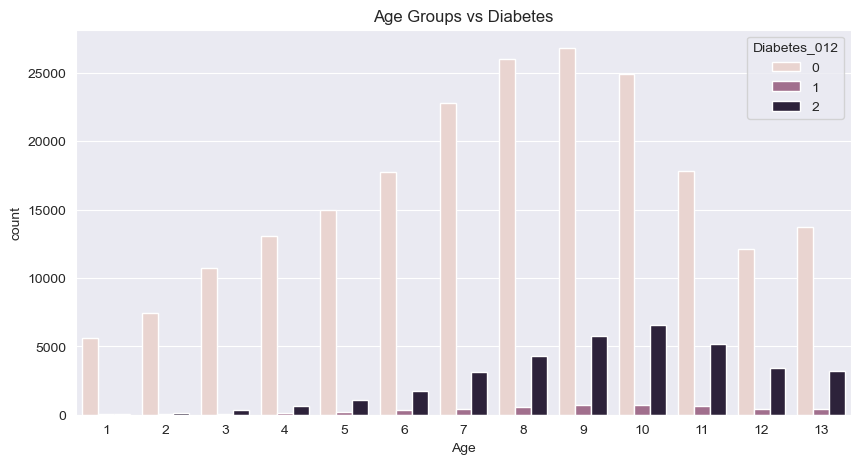

In [18]:
#for age as a categorical variable
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Age', hue='Diabetes_012')
plt.title('Age Groups vs Diabetes')
plt.show()

 

# Machine Learning Algorithms

## Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, make_scorer, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
# === 2. Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# === Set up scaling only for ordinal/continuous columns ===
ordinal_col = ['GenHlth', 'PhysHlth', 'MentHlth','Education', 'Income',"BMI"]
binary_col = [col for col in X.columns if col not in ordinal_col]

preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), ordinal_col)
], remainder='passthrough')  # binary left untouched

# === Full pipeline ===
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('select', SelectKBest(score_func=f_classif)),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

Feature Selection I (SelectKBest, f_classif, with k tuning)

In [ ]:
param_grid = {
    'select__k': list(range(1, 22))  # Try all k values from 1 to 21
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1_macro',  # Or 'recall_macro', etc.
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid.fit(X_train, y_train)

results_df = pd.DataFrame(grid.cv_results_)[['param_select__k', 'mean_test_score', 'mean_train_score']]
results_df.columns = ['k', 'Test Score (F1)', 'Train Score (F1)']
results_df.sort_values('Test Score (F1)', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_dfparam_grid = {
    'select__k': list(range(1, 22))  # Try all k values from 1 to 21
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1_macro',  # Or 'recall_macro', etc.
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid.fit(X_train, y_train)

results_df = pd.DataFrame(grid.cv_results_)[['param_select__k', 'mean_test_score', 'mean_train_score']]
results_df.columns = ['k', 'Test Score (F1)', 'Train Score (F1)']
results_df.sort_values('Test Score (F1)', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df

In [90]:
# === initialize dataframe for readout ===
kbest_df = pd.DataFrame({"Selected Feature": [],
            "Accuracy" : [],
            'Precision': [],
            'Recall':    [],
            'F1 Score':  []})
# === Feature selection with selectKbest ===
for i in range(1,22):
    selector = SelectKBest(score_func=f_classif,k=i)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # === 4. Scale the features ===
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # === 5. Logistic Regression with balanced class weights ===
    lr = LogisticRegression(class_weight='balanced',
                            max_iter=100)
    lr.fit(X_train_scaled, y_train)
    y_pred = lr.predict(X_test_scaled)

    # === 6. Evaluate ===
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    #kbest_df.loc[i, "Selected Feature"] = str(selected_features)
    kbest_df.loc[i, "Accuracy"] = accuracy
    kbest_df.loc[i, 'Precision'] = precision
    kbest_df.loc[i, 'Recall'] = recall
    kbest_df.loc[i, 'F1 Score'] = f1
kbest_df

,Selected Feature,Accuracy,Precision,Recall,F1 Score
1,NaN,0.554360,0.426507,0.460025,0.374199
2,NaN,0.606216,0.423613,0.483322,0.398417
3,NaN,0.645873,0.428486,0.494936,0.414847
4,NaN,0.653776,0.430143,0.495862,0.418367
5,NaN,0.651628,0.435076,0.504430,0.421633
6,NaN,0.646622,0.442077,0.511131,0.424788
7,NaN,0.644454,0.445193,0.511144,0.425527
8,NaN,0.645163,0.445069,0.513353,0.426121
9,NaN,0.647686,0.443905,0.515081,0.425957
10,NaN,0.647804,0.443721,0.515318,0.425728


Feature Selection II (SelectFromModel)

In [29]:
# STEP 2: Scale the features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP 3: Feature selection using SelectFromModel with Logistic Regression
selector_model = LogisticRegression(
    class_weight='balanced',
    penalty='l2',
    solver='saga',
    max_iter=1000)

selector = SelectFromModel(estimator=selector_model)
selector.fit(X_train_scaled, y_train)

X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

# STEP 4: Train a new model using selected features
final_model = LogisticRegression(
    class_weight='balanced',
    penalty='l2',
    solver='saga',
    max_iter=2000,
    random_state=42
)
final_model.fit(X_train_selected, y_train)

# STEP 5: Predict and evaluate
y_pred = final_model.predict(X_test_selected)

# === 6. Evaluate ===
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

# Optional: Detailed class-wise report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy: 0.6457544938505203
Precision (macro): 0.4436835676855276
Recall (macro): 0.5143033936459845
F1-score (macro): 0.42564447720646875

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.66      0.78     42741
           1       0.03      0.28      0.05       926
           2       0.35      0.60      0.45      7069

    accuracy                           0.65     50736
   macro avg       0.44      0.51      0.43     50736
weighted avg       0.85      0.65      0.72     50736



Feature Selection III (backwards stepwise elimination)


 === Logistic Regression Evaluation: ===
Accuracy:  0.6494
Precision: 0.4426
Recall:    0.5210
F1 Score:  0.4264

 === Classification Report: ===
              precision    recall  f1-score   support

           0       0.95      0.67      0.78     42741
           1       0.03      0.30      0.06       926
           2       0.35      0.60      0.44      7069

    accuracy                           0.65     50736
   macro avg       0.44      0.52      0.43     50736
weighted avg       0.85      0.65      0.72     50736


 === Confusion Matrix: ===


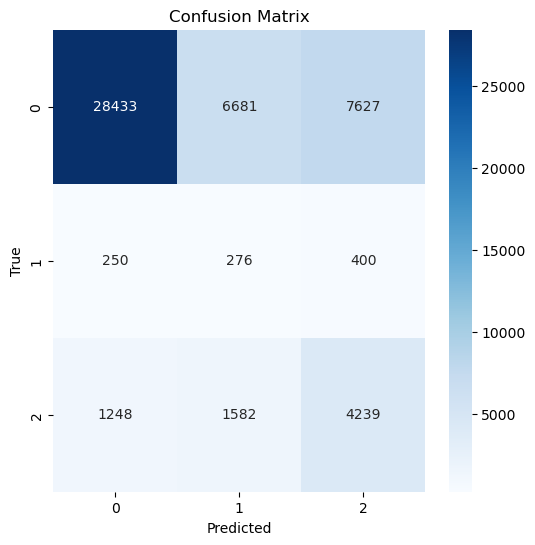

In [24]:
# === 2. Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_postBSE, y, test_size=0.2, random_state=42, stratify=y)

# === 4. Scale the features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Logistic Regression with balanced class weights ===
lr = LogisticRegression(
    class_weight='balanced',
    max_iter=100,
    random_state=42
)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

# === 6. Evaluate ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n === Logistic Regression Evaluation: ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("\n === Classification Report: ===")
print(classification_report(y_test, y_pred))

# === 7. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)

print("\n === Confusion Matrix: ===")
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

first try

c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=21 is greater than n_features=12. All the features will be returned.
  warnings.warn(



 === Logistic Regression Evaluation: ===
Accuracy:  0.6494
Precision: 0.4426
Recall:    0.5210
F1 Score:  0.4264

 === Classification Report: ===
              precision    recall  f1-score   support

           0       0.95      0.67      0.78     42741
           1       0.03      0.30      0.06       926
           2       0.35      0.60      0.44      7069

    accuracy                           0.65     50736
   macro avg       0.44      0.52      0.43     50736
weighted avg       0.85      0.65      0.72     50736


 === Confusion Matrix: ===


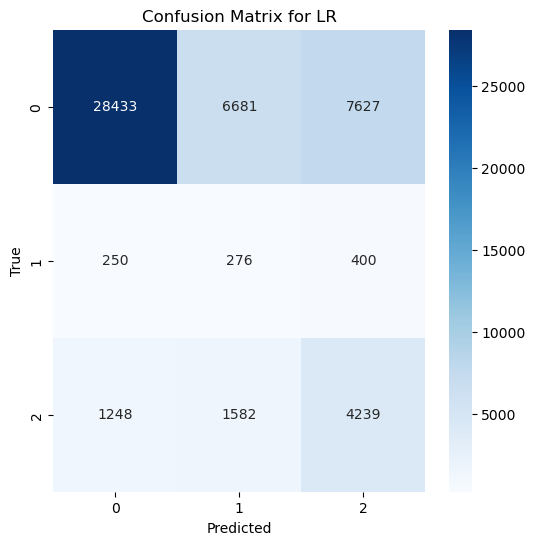

In [31]:
# === 3. Feature selection ===
# Select top 15 features based on ANOVA F-value
selector = SelectKBest(k=21)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# === 4. Scale the features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# === 5. Logistic Regression with balanced class weights ===
lr = LogisticRegression(
    class_weight='balanced',
    max_iter=100,
    random_state=42
)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

# === 6. Evaluate ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n === Logistic Regression Evaluation: ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("\n === Classification Report: ===")
print(classification_report(y_test, y_pred))

# === 7. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)

print("\n === Confusion Matrix: ===")
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for LR')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Hyperparameter tuning

In [30]:
param_grid = {
    'penalty': ['elasticnet'],
    'solver': ['saga'],  # Must match penalty type
    'class_weight': ['balanced'],
    'max_iter': [5000],
    'l1_ratio': [0.5]
}

lr = LogisticRegression()
grid = GridSearchCV(lr, param_grid, cv=4, scoring='f1_macro')
grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best F1 score:", grid.best_score_)

c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'class_weight': 'balanced', 'l1_ratio': 0.5, 'max_iter': 5000, 'penalty': 'elasticnet', 'solver': 'saga'}
Best F1 score: 0.42646136469733725


c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
from sklearn.model_selection import GridSearchCV
recall_macro_scorer = make_scorer(recall_score, average='macro')

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2', None],
    'solver': ['lbfgs'],  # Must match penalty typ
    'class_weight': ['balanced'],
    'max_iter': [100]
}

lr = LogisticRegression()
grid = GridSearchCV(lr, param_grid, cv=5, scoring=recall_macro_scorer)
grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best F1 score:", grid.best_score_)

c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages

Best parameters: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': None, 'solver': 'lbfgs'}
Best F1 score: 0.517157252711282


## Decision Tree

### Assumptions we make while using Decision tree

- At the beginning, we consider the whole training set as the root.
- Attributes are assumed to be categorical for information gain and for gini index, attributes are assumed to be continuous.
- On the basis of attribute values records are distributed recursively.
- We use statistical methods for ordering attributes as root or internal node.

https://www.geeksforgeeks.org/decision-tree-implementation-python/

#### Pseudocode 

1. Find the best attribute and place it on the root node of the tree.
2. Now, split the training set of the dataset into subsets. While making the subset make sure that each subset of training dataset should have the same value for an attribute.
3. Find leaf nodes in all branches by repeating 1 and 2 on each subset.

#### Decision Trees doesn't need to me standartised.

Decision Trees (and related models like Random Forests and Gradient Boosted Trees) are not affected by feature scaling. Here's why:

Trees split data based on feature thresholds, not distances or magnitudes.
For example, a decision tree might split on "Feature X > 5" — it doesn't care whether Feature X is in the range [0,1] or [0, 1000].

##### When you do need standardization:
Standardization (using StandardScaler() or MinMaxScaler()) is important for algorithms that are distance-based or gradient-based, such as:

- K-Nearest Neighbors (KNN)
- Support Vector Machines (SVM)
- Logistic Regression
- Linear Regression
- Neural Networks

These models are sensitive to feature scale and can perform poorly if features are not standardized.

In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# X hole data Frame
# y hale data Frame
"""
# === 2. Train/test split === - Janet
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Split training/test - Oliver
X_train, X_test, y_train, y_test = train_test_split(X_selected_rdf, y, test_size=0.2, random_state=42, stratify=y)

# ==== Train/test split ==== - Noah Light
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.2, stratify=y, random_state=42
)

# ==== 2. TRAIN/TEST SPLIT ==== - Noah neuronal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
"""
# Function to split the dataset into features and target variables

def splitdataset(X, y):

    # Splitting the dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    """ How they did in on geeksforgeeks.org:
    X_train, X_test, y_train, y_test = train_test_split( 
          X, Y, test_size = 0.3, random_state = 100)
    """

    return X_train, X_test, y_train, y_test 

def Evaluation(y_test, y_pred, y_pred_proba=None):
    
    print("Accuracy:", sklearn.metrics.accuracy_score(y_test, y_pred))
    print("Precision:", sklearn.metrics.precision_score(y_test, y_pred, average='macro'))
    print("Recall:", sklearn.metrics.recall_score(y_test, y_pred, average='macro'))
    print("F1 Score:", sklearn.metrics.f1_score(y_test, y_pred, average='macro'))
    if(y_pred_proba):
        print("Log Loss:", sklearn.metrics.log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
    print("Cohen Kappa Score:", sklearn.metrics.cohen_kappa_score(y_test, y_pred))

In [ ]:
# testing first on the hole data set and again with feature selection
X_train, X_test, y_train, y_test = splitdataset(X,y)
#DataSetSplit_Reduced = splitdataset(X_reducedRelevant,y)

dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)

y_predicted = dtree.predict(X_test)
Accurat = accuracy_score(y_test, y_predicted)
F1 = f1_score(y_test, y_predicted, average='weighted')
print(f"accuracy: {Accurat}")
print(f"F1: {F1}")

X_train, X_test, y_train, y_test = splitdataset(X_postBSE,y)

dtree = DecisionTreeClassifier(max_depth=5)
dtree = dtree.fit(X_train, y_train)

y_predicted = dtree.predict(X_test)
Accurat = accuracy_score(y_test, y_predicted)
F1 = f1_score(y_test, y_predicted, average='weighted')
print(f"accuracy: {Accurat}")
print(f"F1: {F1}")

Evaluation(y_test, y_predicted)
""" ploting desicion tree
plt.figure(figsize=(40, 10))
sklearn.tree.plot_tree(dtree, feature_names=newList)
plt.show()
"""


In [ ]:
criterions = ["gini", "entropy"]
maxDepth = [2,4,8,16,32]

for criterion in criterions:
    for d in maxDepth:
        
        print("=========  Method: " + criterion + ", maxDepth: " + str(d) + " ========\n")
        dtree = DecisionTreeClassifier(criterion=criterion, max_depth=d)
        dtree.fit(X_train, y_train)
        y_predicted = dtree.predict(X_test)
        Evaluation(y_test, y_predicted)

In [ ]:
"""
#training a decision tree classifier using the Gini index as the splitting criterion
def train_using_gini(X_train, X_test, y_train):

    # Creating the classifier object
    clf_gini = DecisionTreeClassifier(criterion="gini",
                                      random_state=42, max_depth=3, min_samples_leaf=5)

    # Performing training
    clf_gini.fit(X_train, y_train)
    return clf_gini


def train_using_entropy(X_train, X_test, y_train):

    # Decision tree with entropy
    clf_entropy = DecisionTreeClassifier(
        criterion="entropy", random_state=42,
        max_depth=3, min_samples_leaf=5)

    # Performing training
    clf_entropy.fit(X_train, y_train)
    return clf_entropy
"""

## Random Forest

Selected features: Index(['HighBP', 'HighChol', 'BMI', 'Smoker', 'HeartDiseaseorAttack',
       'PhysActivity', 'Fruits', 'GenHlth', 'DiffWalk', 'Age'],
      dtype='object')


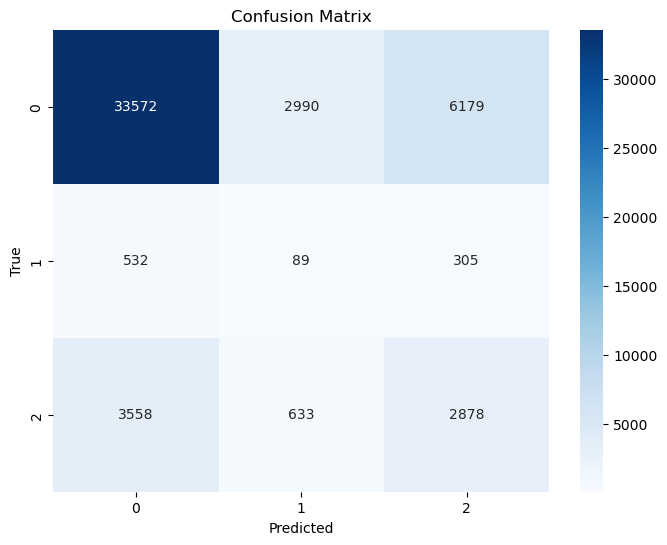

Random Forest Classifier
Accuracy: 0.7201789656259855
Precision: 0.40759723789934804
Recall: 0.4295724456920234
F1 Score: 0.40792842043755667
Log Loss: 1.3613745962207169
Cohen Kappa Score: 0.19502834505517352


In [6]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             log_loss, cohen_kappa_score, classification_report, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Split the data into training and testing sets
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Select the features
rdf_selector = SelectKBest(score_func=mutual_info_classif, k=10)
rdf_selector.fit(X_scaled, y)
X_rdf= rdf_selector.transform(X_scaled)
selected_features = X.columns[rdf_selector.get_support()]

print("Selected features:", selected_features)

# Create a dataframe with the selected features
X_selected_rdf = pd.DataFrame(X_rdf, columns=selected_features, index=data.index)

# RANDOM FOREST
rdf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Split training/test
X_train, X_test, y_train, y_test = train_test_split(X_selected_rdf, y, test_size=0.2, random_state=42, stratify=y)

# Fit the model
rdf.fit(X_train, y_train)

# Prediction
y_pred = rdf.predict(X_test)
y_pred_proba = rdf.predict_proba(X_test)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))



Random forest feature selection

Top Random Forest Features: ['BMI' 'Age' 'Income' 'PhysHlth' 'Education' 'GenHlth']


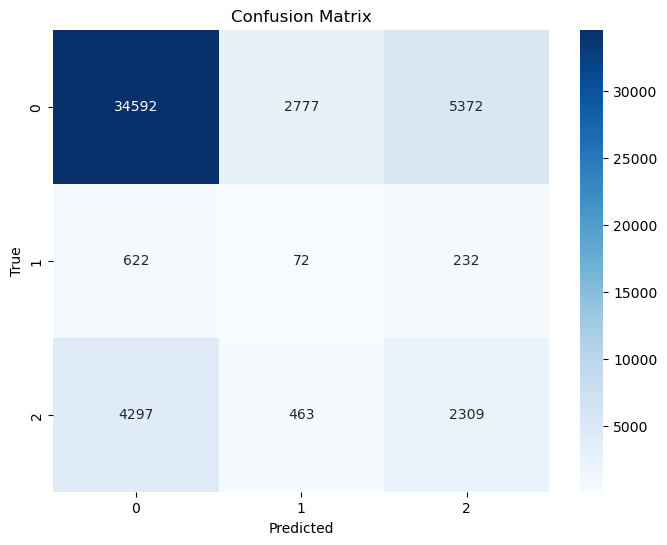

Random Forest Classifier
Accuracy: 0.7287330495111952
Precision: 0.39634682049769393
Recall: 0.4045770629138706
F1 Score: 0.39444574883091293
Log Loss: 1.2424020885623102
Cohen Kappa Score: 0.15503249876643


In [23]:
# Train a Random Forest to get feature importances
temp_rdf = RandomForestClassifier(class_weight='balanced', random_state=42)
temp_rdf.fit(X, y)

# Get feature importances
importances = temp_rdf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select top k important features
k=6
top_features = importance_df['Feature'].head(k).values
print("Top Random Forest Features:", top_features)

# Use only the selected features
X_selected_rf = pd.DataFrame(X, columns=X.columns)[top_features]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_selected_rf, y, test_size=0.2, random_state=42, stratify=y)

# Train final model
rdf = RandomForestClassifier(class_weight='balanced', random_state=42)
rdf.fit(X_train, y_train)

# Predict
y_pred = rdf.predict(X_test)
y_pred_proba = rdf.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))

HPT after FS RF

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bootstrap=True, class_weight={0: 1, 1: 10, 2: 5}, max_depth=15, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   5.3s
[CV] END bootstrap=True, class_weight={0: 1, 1: 10, 2: 5}, max_depth=15, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   5.4s
[CV] END bootstrap=True, class_weight={0: 1, 1: 10, 2: 5}, max_depth=15, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   5.5s
[CV] END bootstrap=True, class_weight={0: 1, 1: 10, 2: 5}, max_depth=15, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   5.3s
[CV] END bootstrap=True, class_weight={0: 1, 1: 10, 2: 5}, max_depth=15, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   5.4s
[CV] END bootstrap=True, class_weight={0: 1, 1: 15, 2: 10}, max_depth=10, max_features=0.5, m

/Users/miniconda3/envs/jupyter/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, class_weight={0: 1, 1: 15, 2: 10}, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=  11.2s
[CV] END bootstrap=True, class_weight={0: 1, 1: 15, 2: 10}, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=  11.5s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  17.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  17.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  17.4s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  17.2s
[CV] END bootstrap=Tru

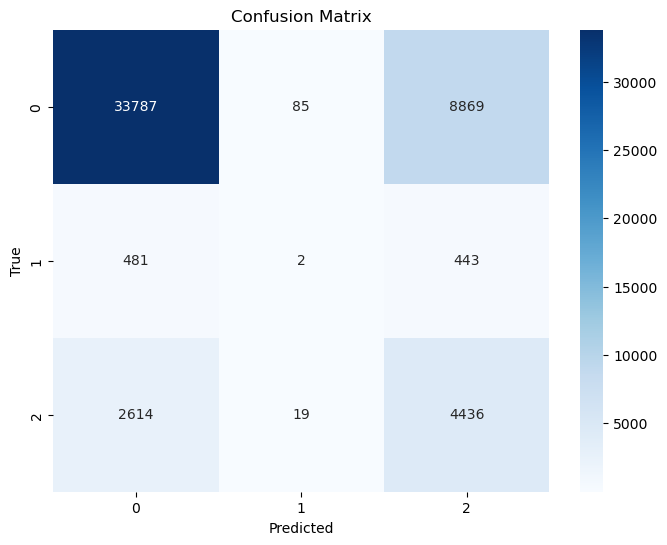

Best parameters from tuning: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15, 'class_weight': {0: 1, 1: 10, 2: 5}, 'bootstrap': True}
Best CV score: 0.42768659273793574
Accuracy: 0.753409807631662
Precision (macro): 0.4192055886443835
Recall (macro): 0.4733980256448061
F1 Score (macro): 0.4262468266876418

Classification Report:

              precision    recall  f1-score   support

           0     0.9161    0.7905    0.8487     42741
           1     0.0189    0.0022    0.0039       926
           2     0.3227    0.6275    0.4262      7069

    accuracy                         0.7534     50736
   macro avg     0.4192    0.4734    0.4262     50736
weighted avg     0.8170    0.7534    0.7744     50736



In [29]:
from sklearn.model_selection import StratifiedKFold
#==== Train-test split ====
# Split training/test
X_train, X_test, y_train, y_test = train_test_split(X_selected_rf, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)

# ==== Parametri per RandomizedSearch ====
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False],
    'class_weight': ['balanced', {0:1, 1:10, 2:5}, {0:1, 1:15, 2:10}]
}

# ==== RandomizedSearch ====
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# ==== Fit ====
random_search.fit(X_train, y_train)


# ==== Best Model ====
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# ==== Confusion Matrix ====
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ==== Metrics ====
print("Best parameters from tuning:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


HPT for random forest I

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif

"""
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_selector = SelectKBest(score_func=f_classif,k=9)
rdf_selector.fit(X_scaled, y)
X_rdf= rdf_selector.transform(X_scaled)
selected_features = X.columns[rdf_selector.get_support()]

print("Selected features:", selected_features)

# Create a dataframe with the selected features
X_selected_rdf = pd.DataFrame(X_rdf, columns=selected_features, index=data.index)
"""

# Split training/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)

param_dist = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.5, 0.8, None],
    'bootstrap': [True, False]
}

# Random search

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='f1_macro',  # puoi cambiare qui
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

"""
# Miglior modello
best_rf = random_search.best_estimator_


# Valutazione sul test set
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)


# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Metrics
print("Best parameters from tuning:", random_search.best_params_)
print("Accuracy:", best_rf.score(X_test, y_test))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))
"""

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=  16.1s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=  16.2s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=  16.3s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=  16.4s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=  16.5s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=10; total time=  25.4s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=10; total time=  25.6s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=10; to

/Users/miniconda3/envs/jupyter/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=  56.9s
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=  56.4s
[CV] END bootstrap=False, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=  55.8s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=2; total time=  30.9s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=2; total time=  31.3s
[CV] END bootstrap=True, max_depth=5, max_features=0.5, min_samples_leaf=4, min_samples_split=2; total time=   6.7s
[CV] END bootstrap=True, max_depth=5, max_features=0.5, min_samples_leaf=4, min_samples_split=2; total time=   7.1s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=2; total time=  31.4s
[CV] END bootstrap=True, max_depth=5, max_features=

'\n# Miglior modello\nbest_rf = random_search.best_estimator_\n\n\n# Valutazione sul test set\ny_pred = best_rf.predict(X_test)\ny_proba = best_rf.predict_proba(X_test)\n\n\n# Confusion matrix\ncm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])\nplt.figure(figsize=(8, 6))\nsns.heatmap(cm, annot=True, fmt=\'d\', cmap=\'Blues\')\nplt.title(\'Confusion Matrix\')\nplt.xlabel(\'Predicted\')\nplt.ylabel(\'True\')\nplt.show()\n\n# Metrics\nprint("Best parameters from tuning:", random_search.best_params_)\nprint("Accuracy:", best_rf.score(X_test, y_test))\nprint("Precision (macro):", precision_score(y_test, y_pred, average=\'macro\'))\nprint("Recall (macro):", recall_score(y_test, y_pred, average=\'macro\'))\nprint("F1 Score (macro):", f1_score(y_test, y_pred, average=\'macro\'))\nprint("\nClassification Report:\n")\nprint(classification_report(y_test, y_pred, digits=4))\n'

In [17]:
"""
#  ==== Scaling ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==== Feature selection ====
selector = SelectKBest(score_func=f_classif, k=9)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_selected, columns=selected_features, index=data.index)
"""
# ==== Train-test split ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ==== Pipeline ====
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# ==== Parametri per RandomizedSearch ====
param_dist = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [5, 10, 15, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', 0.5],
    'rf__bootstrap': [True, False],
    'rf__class_weight': ['balanced', {0:1, 1:10, 2:5}, {0:1, 1:15, 2:10}]
}

# ==== RandomizedSearch ====
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# ==== Fit ====
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

"""
# ==== Best Model ====
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# ==== Confusion Matrix ====
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ==== Metrics ====
print("Best parameters from tuning:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))
"""

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 10, 2: 5}, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  54.8s
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 10, 2: 5}, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  56.4s
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 10, 2: 5}, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  56.6s
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 10, 2: 5}, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=50; total time=  48.1s
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 10, 2: 5}, rf__max_depth=15, rf__max_features=0.5, rf__min_samples_leaf=4, rf__min_samples_spl

/Users/miniconda3/envs/jupyter/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 15, 2: 10}, rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=150; total time= 1.1min
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 15, 2: 10}, rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=150; total time= 1.1min
[CV] END rf__bootstrap=True, rf__class_weight=balanced, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=150; total time= 1.6min
[CV] END rf__bootstrap=True, rf__class_weight={0: 1, 1: 15, 2: 10}, rf__max_depth=10, rf__max_features=log2, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=150; total time= 1.1min
[CV] END rf__bootstrap=True, rf__class_weight=balanced, rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=150; total time= 1.6min
[CV] END rf__bootstrap=

KeyboardInterrupt: 

SMOTE + RF. Let's see

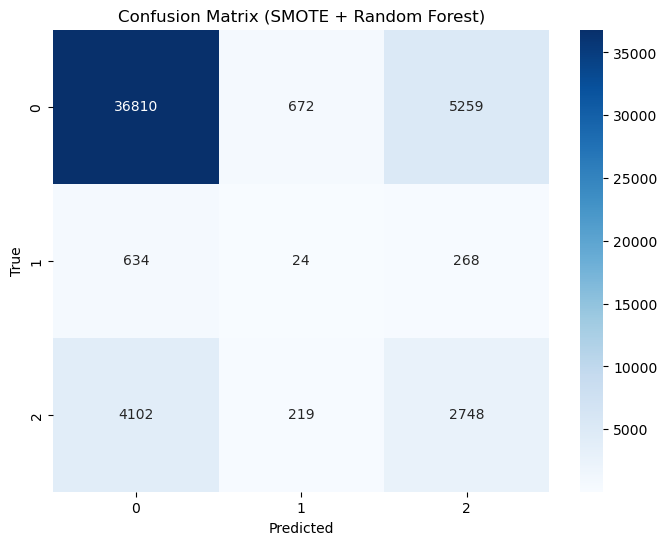

Random Forest Classifier with SMOTE
Accuracy: 0.7801561021759698
Precision (macro): 0.41477332444998943
Recall (macro): 0.4252971458927152
F1 Score (macro): 0.41923423331049
Log Loss: 1.4077177184555372
Cohen Kappa Score: 0.23430657440459035

Classification Report:

              precision    recall  f1-score   support

           0     0.8860    0.8612    0.8734     42741
           1     0.0262    0.0259    0.0261       926
           2     0.3321    0.3887    0.3582      7069

    accuracy                         0.7802     50736
   macro avg     0.4148    0.4253    0.4192     50736
weighted avg     0.7931    0.7802    0.7862     50736



In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Pipeline con SMOTE + Random Forest
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Fit della pipeline sul training set
pipeline.fit(X_train, y_train)

# Predizione sul test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (SMOTE + Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier with SMOTE")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))

# Classification report per classe
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

Let's try an undersampling

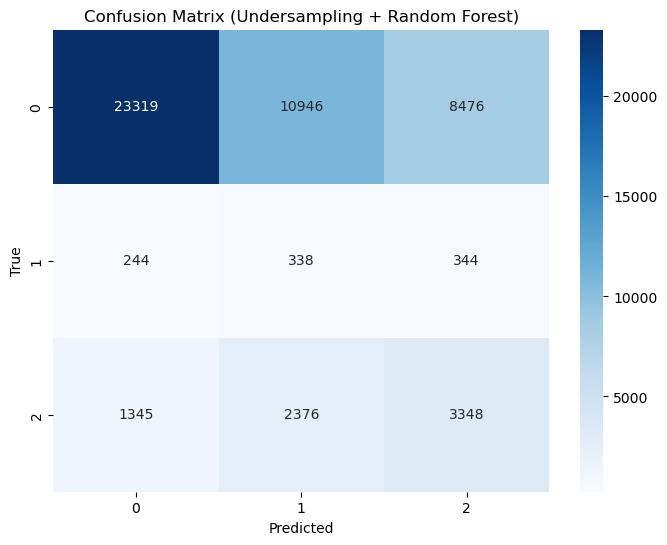

Random Forest Classifier with Random Undersampling
Accuracy: 0.5322650583412173
Precision (macro): 0.41203231390409223
Recall (macro): 0.46140551532007
F1 Score (macro): 0.3612788515394219
Log Loss: 1.5127676052973147
Cohen Kappa Score: 0.14662302711755804

Classification Report:

              precision    recall  f1-score   support

           0     0.9362    0.5456    0.6894     42741
           1     0.0247    0.3650    0.0463       926
           2     0.2751    0.4736    0.3481      7069

    accuracy                         0.5323     50736
   macro avg     0.4120    0.4614    0.3613     50736
weighted avg     0.8275    0.5323    0.6301     50736



In [8]:
from imblearn.under_sampling import RandomUnderSampler


# Pipeline con Undersampling + Random Forest
pipeline = Pipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Fit della pipeline sul training set
pipeline.fit(X_train, y_train)

# Predizione sul test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Undersampling + Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier with Random Undersampling")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))

# Classification report per classe
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

BalancedBaggingClassifier. I'm trying to find a better classifier for very unbalanced dataset. This one uses trained undersample. Let's see

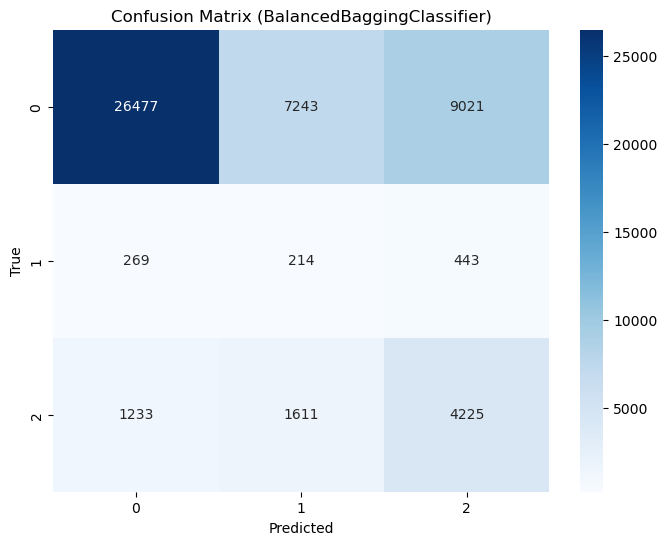

BalancedBaggingClassifier with RandomForest
Accuracy: 0.6093503626616209
Precision (macro): 0.42618610883075053
Recall (macro): 0.4827523227730059
F1 Score (macro): 0.3995605347734987
Log Loss: 0.854432185795542
Cohen Kappa Score: 0.2101434349881398

Classification Report:

              precision    recall  f1-score   support

           0     0.9463    0.6195    0.7488     42741
           1     0.0236    0.2311    0.0428       926
           2     0.3086    0.5977    0.4071      7069

    accuracy                         0.6094     50736
   macro avg     0.4262    0.4828    0.3996     50736
weighted avg     0.8406    0.6094    0.6883     50736



In [11]:
from imblearn.ensemble import BalancedBaggingClassifier

# Balanced Bagging with Random Forest as base estimator
bbc = BalancedBaggingClassifier(
    estimator=RandomForestClassifier(random_state=42),
    sampling_strategy='auto',  # Bilancia automaticamente le classi
    replacement=False,
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)

# Fit del modello
bbc.fit(X_train, y_train)

# Predizione
y_pred = bbc.predict(X_test)
y_pred_proba = bbc.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (BalancedBaggingClassifier)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Valutazione
print("BalancedBaggingClassifier with RandomForest")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

XGBoost. Also good for very unbalanced dataset

Class Weights: {0: np.float64(0.395690270352476), 1: np.float64(18.258569500674763), 2: np.float64(2.392332991477172)}


/Users/miniconda3/envs/jupyter/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:02:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1747336884418/work/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


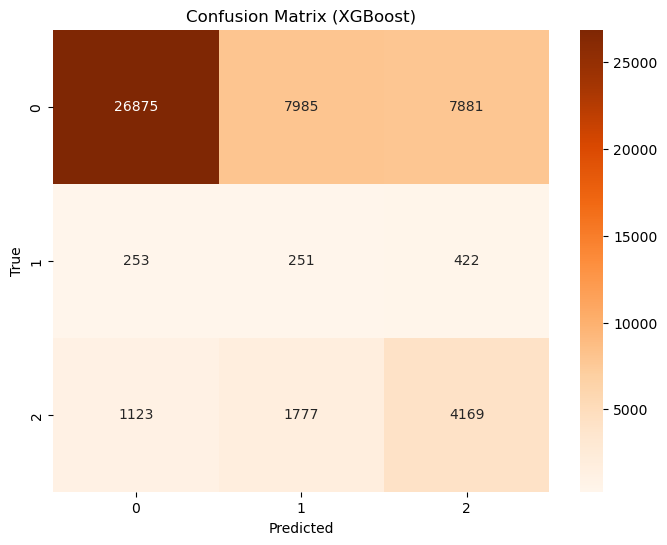

XGBoost Classifier
Accuracy: 0.616820403658152
Precision (macro): 0.4368766446346016
Recall (macro): 0.496534587039859
F1 Score (macro): 0.4099036693268843
Log Loss: 0.8462874219575712
Cohen Kappa Score: 0.22286797806863068

Classification Report:

              precision    recall  f1-score   support

           0     0.9513    0.6288    0.7571     42741
           1     0.0251    0.2711    0.0459       926
           2     0.3343    0.5898    0.4267      7069

    accuracy                         0.6168     50736
   macro avg     0.4369    0.4965    0.4099     50736
weighted avg     0.8484    0.6168    0.6981     50736



In [13]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

# Calcolo pesi delle classi per XGBoost
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

# Inizializza XGBoost
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=1  # Ignorato in multiclass, usiamo sample_weight
)

# Fit con sample_weight
sample_weights = y_train.map(class_weights_dict)
xgb.fit(X_train, y_train, sample_weight=sample_weights)

# Predict
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("XGBoost Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

## Lightgbm

Diabetes_012
0    0.842412
2    0.139333
1    0.018255
Name: proportion, dtype: float64


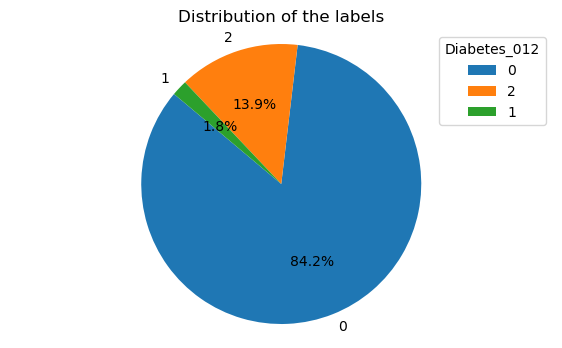

In [54]:
print(y.value_counts(normalize=True)) ##High imbalance --> Oversampling 
#Plot
plt.figure(figsize=(7, 4))
plt.pie(data['Diabetes_012'].value_counts(), labels=data['Diabetes_012'].value_counts().index,autopct='%1.1f%%' , startangle=140)
plt.title('Distribution of the labels')
plt.legend(title='Diabetes_012')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('pie_chart.png', dpi=300, bbox_inches='tight')
plt.show()

Dropping 'PhysActivity' with p = 0.7308
Dropping 'DiffWalk' with p = 0.5998
Dropping 'Smoker' with p = 0.5562
Dropping 'HeartDiseaseorAttack' with p = 0.5250
Dropping 'Fruits' with p = 0.4939
Dropping 'AnyHealthcare' with p = 0.2242
Dropping 'NoDocbcCost' with p = 0.1240
Dropping 'Veggies' with p = 0.1182
Dropping 'Stroke' with p = 0.0915
Selected features: ['const', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'Sex', 'Age', 'Education', 'Income']
Class weights: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0)}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2580
[LightGBM] [Info] Number of data points in the train set: 512886, number of used features: 12
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -

C:\Users\noah\anaconda3\envs\FODS\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\noah\anaconda3\envs\FODS\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\noah\anaconda3\envs\FODS\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\noah

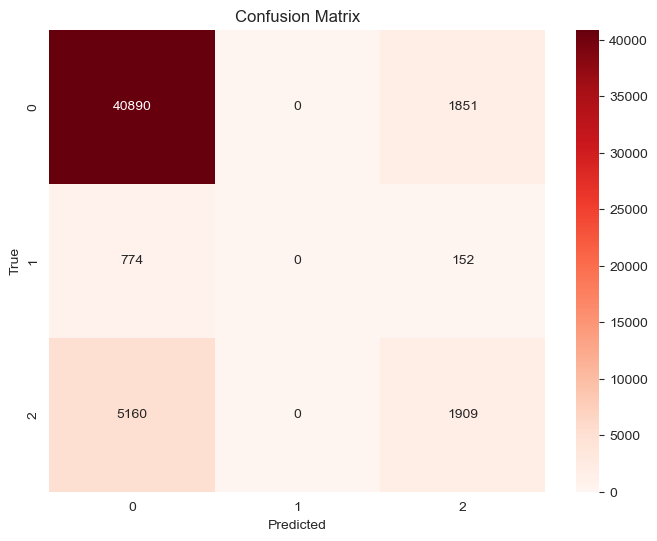

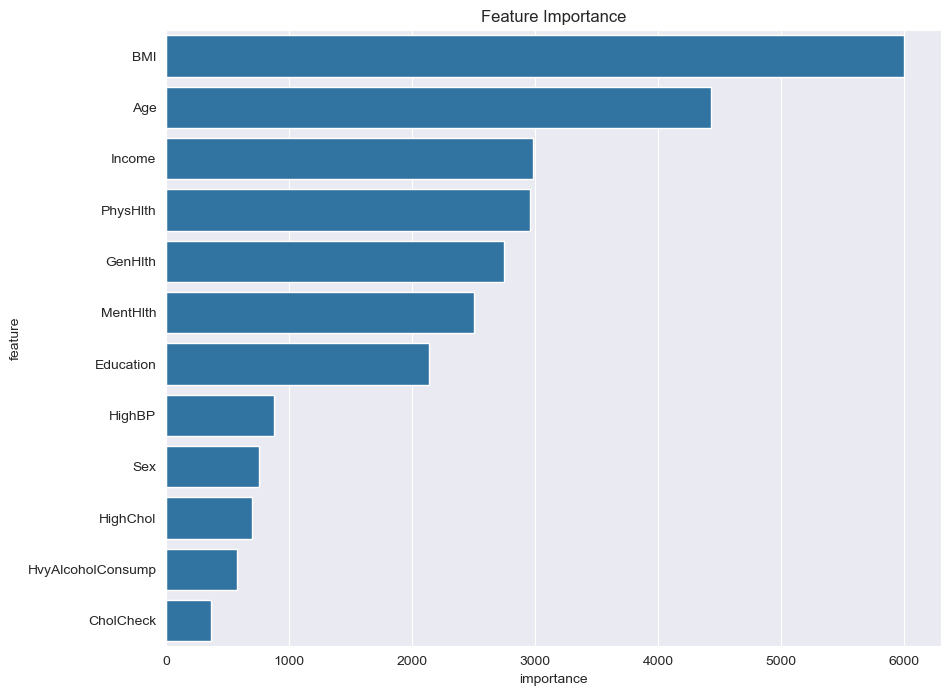

In [23]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, cohen_kappa_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter
# ==== Preprocessing ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# ==== Selezione delle migliori features ====
selected_cols = multinomial(X_scaled_df)
if 'const' in selected_cols:
    selected_cols.remove('const')
X_model = X_scaled_df[selected_cols]

# ==== Train/test split ====
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.2, stratify=y, random_state=42
)

# ==== Oversampling SMOTE ====
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# ==== Calcolo class_weight ====
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_bal), y=y_train_bal)
class_weight_dict = dict(zip(np.unique(y_train_bal), class_weights))
print("Class weights:", class_weight_dict)

# ==== Modello LightGBM ====
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    learning_rate=0.05,
    n_estimators=300,
    class_weight=class_weight_dict,
    random_state=42
)
model.fit(
    X_train_bal, y_train_bal,
    eval_set=[(X_test, y_test)],
    eval_metric='multi_logloss',
    callbacks=[lgb.early_stopping(50)]
)

# ==== Predizioni ====
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)

# ==== Valutazione ====
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, digits=4))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Log Loss: {log_loss(y_test, y_pred_probs):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.4f}")

# ==== Confusion Matrix ====
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ==== Feature Importance ====
importance = model.feature_importances_
feature_names = X_model.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

## Multiclass Classification Neural Network

Scaling and get_dummies

In [ ]:

from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Scale continuous variables
continuous = ['BMI', 'MentHlth', 'PhysHlth']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[continuous])
X_scaled = pd.DataFrame(X_scaled, columns=continuous, index=X.index)

# 2. One-hot encode ordinal variables
X_onehot = pd.get_dummies(X[['Age', 'Education', 'Income']], drop_first=True)

# 3. Keep binary variables
binary_vars = X.drop(columns=continuous + ['Age', 'Education', 'Income'])
X_processed = pd.concat([X_scaled, X_onehot, binary_vars], axis=1)


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, log_loss,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss

# ==== 2. SPLIT TRAIN/TEST ====
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, stratify=y, random_state=42
)

# ==== 3. SMOTE RESAMPLING ====
sm = SMOTE(sampling_strategy={1: 40000, 2: 40000}, random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)


# ==== 4. TORCH DATASET ====
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values if isinstance(y, pd.Series) else y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = DiabetesDataset(X_resampled, y_resampled)
test_dataset = DiabetesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# ==== 5. MODEL DEFINITION ====
class DiabetesModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        """
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 3)
        )
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )"""
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.model(x)


# ==== 6. FOCAL LOSS ====
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        return -((1 - pt) ** self.gamma) * logpt


# ==== 7. MODEL SETUP ====
model = DiabetesModel(X_processed.shape[1])

# Compute class weights from resampled set
class_counts = pd.Series(y_resampled).value_counts().sort_index()
weights = 1. / torch.tensor(class_counts.values, dtype=torch.float32)
weights = weights / weights.sum()

#criterion = FocalLoss(gamma=1.5, weight=weights)
criterion = FocalLoss(gamma=2.0, weight=None)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50


def compute_f1_by_class(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())
    return f1_score(y_true, y_pred, average=None)


# ==== 8. TRAINING LOOP ====
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.4f}")
    if (epoch + 1) % 5 == 0:
        f1s = compute_f1_by_class(model, test_loader)
        print(f"F1 per classe - Epoch {epoch + 1}: 0: {f1s[0]:.4f}, 1: {f1s[1]:.4f}, 2: {f1s[2]:.4f}")

# ==== 9. EVALUATION ====
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(targets.tolist())
        y_pred.extend(preds.tolist())
        y_probs.extend(probs.tolist())

# ==== 10. METRICS ====
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

print(f"Accuracy:          {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Recall (macro):    {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (weighted): {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"F1-score (macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Log Loss: {log_loss(y_true, y_probs):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

# ==== 11. CONFUSION MATRIX ====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()


General Scaling and no features selection

Epoch 1/30, Loss: 3497.8284
Epoch 2/30, Loss: 3318.8730
Epoch 3/30, Loss: 3224.0311
Epoch 4/30, Loss: 3164.5853
Epoch 5/30, Loss: 3127.6282
Epoch 6/30, Loss: 3092.7965
Epoch 7/30, Loss: 3064.3518
Epoch 8/30, Loss: 3045.7772
Epoch 9/30, Loss: 3028.4297
Epoch 10/30, Loss: 3007.9048
Epoch 11/30, Loss: 2993.3491
Epoch 12/30, Loss: 2982.5914
Epoch 13/30, Loss: 2973.4740
Epoch 14/30, Loss: 2963.9542
Epoch 15/30, Loss: 2955.3092
Epoch 16/30, Loss: 2944.3504
Epoch 17/30, Loss: 2940.1772
Epoch 18/30, Loss: 2933.6689
Epoch 19/30, Loss: 2922.9924
Epoch 20/30, Loss: 2918.8513
Epoch 21/30, Loss: 2911.3387
Epoch 22/30, Loss: 2910.0014
Epoch 23/30, Loss: 2902.5094
Epoch 24/30, Loss: 2905.1609
Epoch 25/30, Loss: 2900.0250
Epoch 26/30, Loss: 2902.3555
Epoch 27/30, Loss: 2885.8035
Epoch 28/30, Loss: 2887.3257
Epoch 29/30, Loss: 2883.3565
Epoch 30/30, Loss: 2876.4042

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.95      0.62      0.75     42741

C:\Users\noah\anaconda3\envs\FODS\Lib\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


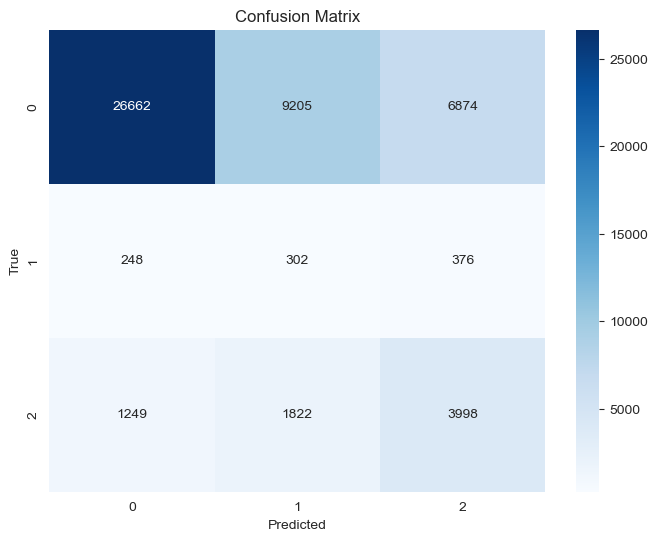

In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, log_loss,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# ==== 2. SPLIT TRAIN/TEST ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==== 3. SCALING ====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==== 4. SMOTE RESAMPLING ====
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)

# ==== 5. CUSTOM DATASET ====
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if isinstance(y, pd.Series) else y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DiabetesDataset(X_resampled, y_resampled)
test_dataset = DiabetesDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ==== 6. MODEL DEFINITION ====
class DiabetesModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.model(x)

# ==== 7. FOCAL LOSS ====
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        return -((1 - pt) ** self.gamma) * logpt

# ==== 8. MODEL SETUP ====
model = DiabetesModel(X.shape[1])

# Compute class weights based on inverse frequency (from resampled training set)
class_counts = pd.Series(y_resampled).value_counts().sort_index()
weights = 1. / torch.tensor(class_counts.values, dtype=torch.float)
weights = weights / weights.sum()

criterion = FocalLoss(gamma=1.5, weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 30

# ==== 9. TRAINING LOOP ====
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")

# ==== 10. EVALUATION ====
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(targets.tolist())
        y_pred.extend(preds.tolist())
        y_probs.extend(probs.tolist())

# ==== 11. METRICS ====
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

print(f"Accuracy:          {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Recall (macro):    {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (weighted): {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"F1-score (macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Log Loss: {log_loss(y_true, y_probs):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

# ==== 12. CONFUSION MATRIX ====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()




In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, log_loss,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# ==== 2. SPLIT TRAIN/TEST ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==== 3. SCALING ====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==== 4. SMOTE RESAMPLING ====
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)


# ==== 5. CUSTOM DATASET ====
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if isinstance(y, pd.Series) else y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = DiabetesDataset(X_resampled, y_resampled)
test_dataset = DiabetesDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# ==== 6. MODEL DEFINITION ====
class DiabetesModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.model(x)


# ==== 7. FOCAL LOSS ====
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        return -((1 - pt) ** self.gamma) * logpt


# ==== 8. MODEL SETUP ====
model = DiabetesModel(X.shape[1])

# Compute class weights based on inverse frequency (from resampled training set)
class_counts = pd.Series(y_resampled).value_counts().sort_index()
weights = 1. / torch.tensor(class_counts.values, dtype=torch.float)
weights = weights / weights.sum()

criterion = FocalLoss(gamma=1.5, weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 30

# ==== 9. TRAINING LOOP ====
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.4f}")

# ==== 10. EVALUATION ====
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(targets.tolist())
        y_pred.extend(preds.tolist())
        y_probs.extend(probs.tolist())

# ==== 11. METRICS ====
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

print(f"Accuracy:          {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Recall (macro):    {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (weighted): {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"F1-score (macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Log Loss: {log_loss(y_true, y_probs):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

# ==== 12. CONFUSION MATRIX ====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()


With features selection(multinomial)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, log_loss,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ==== 2. FEATURE SELECTION (Multinomial logistic regression) ====

selected_cols = multinomial(X)
if 'const' in selected_cols:
    selected_cols.remove('const')
X_model = X[selected_cols]

# ==== 3. SPLIT TRAIN/TEST ====
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.2, stratify=y, random_state=42
)

# ==== 4. SCALING ====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==== 5. SMOTE ====
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)


# ==== 6. TORCH DATASET ====
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, pd.DataFrame) or isinstance(X, np.ndarray):
            X = np.array(X)
        if isinstance(y, pd.Series):
            y = y.values
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = DiabetesDataset(X_resampled, y_resampled)
test_dataset = DiabetesDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# ==== 7. MODEL ====
class DiabetesModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.model(x)


# ==== 8. FOCAL LOSS ====
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        return -((1 - pt) ** self.gamma) * logpt


# ==== 9. TRAIN SETUP ====
input_dim = X_resampled.shape[1]
model = DiabetesModel(input_dim)

class_counts = pd.Series(y_resampled).value_counts().sort_index()
weights = 1. / torch.tensor(class_counts.values, dtype=torch.float)
weights = weights / weights.sum()

criterion = FocalLoss(gamma=1.5, weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 30

# ==== 10. TRAIN LOOP ====
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.4f}")

# ==== 11. EVALUATION ====
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(targets.tolist())
        y_pred.extend(preds.tolist())
        y_probs.extend(probs.tolist())

# ==== 12. METRICS ====
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"Log Loss: {log_loss(y_true, y_probs):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

# ==== 13. CONFUSION MATRIX ====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_2.png")
plt.show()

With features selection(kbest)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, log_loss,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# 1. Feature selection
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_selected = selector.fit_transform(X, y)  # restituisce un ndarray con 10 feature

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# 5. input_dim per la rete
input_dim = X_resampled.shape[1]


# ==== 6. TORCH DATASET ====
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, pd.DataFrame) or isinstance(X, np.ndarray):
            X = np.array(X)
        if isinstance(y, pd.Series):
            y = y.values
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = DiabetesDataset(X_resampled, y_resampled)
test_dataset = DiabetesDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# ==== 7. MODEL ====
class DiabetesModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.model(x)


# ==== 8. FOCAL LOSS ====
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        return -((1 - pt) ** self.gamma) * logpt


# ==== 9. TRAIN SETUP ====

model = DiabetesModel(input_dim)

class_counts = pd.Series(y_resampled).value_counts().sort_index()
weights = 1. / torch.tensor(class_counts.values, dtype=torch.float)
weights = weights / weights.sum()

criterion = FocalLoss(gamma=1.5, weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 30

# ==== 10. TRAIN LOOP ====
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.4f}")

# ==== 11. EVALUATION ====
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(targets.tolist())
        y_pred.extend(preds.tolist())
        y_probs.extend(probs.tolist())

# ==== 12. METRICS ====
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"Log Loss: {log_loss(y_true, y_probs):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

# ==== 13. CONFUSION MATRIX ====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_3.png")
plt.show()